In [48]:
import torch
import torch.nn as nn
import torchvision.transforms as tfms
from typing import List

from PIL import Image
import matplotlib.pylab as plt
import numpy as np

import glob
from data import get_ds_dl
from model import get_resnet
from export import create_session, predict

import pandas as pd

%matplotlib inline

### Test ONNX on files from validation set

##### Change the following cell

onnx_file: point to which model you want to test

fname_list: pick which set of images you want to run the model over to evaluate accuracy

In [52]:
ls saved_models

current_model    train_aug29/                 train_aug29_edges/
rps_latest.onnx  train_aug29_contoursnobase/


In [61]:
#CHANGE THIS TO TEST MODEL
train_folder = '../Rock-Paper-Scissors/train_aug29'
test_folder = '../Rock-Paper-Scissors/test_aug29'

onnx_file = 'saved_models/train_aug29/train_aug29.onnx'

train_fnames = glob.glob(f'{train_folder}/*/*')
test_fnames = glob.glob(f'{test_folder}/*/*')

fname_list = test_fnames #PICK WHICH IMAGES YOU WANT TO TEST OVER

In [62]:
ds_train, ds_test, dl_train, dl_test = get_ds_dl(None, 
                                                 1,
                                                 train_folder,
                                                 test_folder)
classes = ds_train.classes

In [63]:
_, transform = get_resnet()
transform = tfms.Compose([transform, 
                          tfms.RandomRotation(45),
                          tfms.RandomHorizontalFlip()])

In [64]:
sess = create_session(onnx_file)

In [65]:
print(len(train_fnames))
print(len(test_fnames))

102
25


In [70]:
#fname_list = train_fnames
#fname_list = test_fnames #PICK WHICH IMAGES YOU WANT TO TEST OVER
plot = False
total = 0
incorrect = []
incorrect_idx = []

for idx in range(len(fname_list)):
    fname = fname_list[idx]

    #get predictions and labels
    pred = predict(sess, fname, transform)
    label = fname.split("/")[-2]
    pred_class = classes[pred.argmax()]

    if label==pred_class: #only look at incorrect predictions
        continue
    
    if plot:
        plt.figure()
        plt.imshow(Image.open(fname).convert('RGB')) #plot raw image
        _ = plt.title(f'label = {label} pred = {pred_class} \n pred_logits = {pred}\n classes = {classes}')
    
    total += 1 #a counter to limit how many examples being looked at
    incorrect.append((label, pred_class, pred))
    incorrect_idx.append(idx)
    #if total > 10:
    #    break

##### Results

In [67]:
print(f"% of incorrect preds: {len(incorrect) / len(fname_list):.3f}")

% of incorrect preds: 0.240


In [68]:
print("Distribution of incorrect predictions:")
df = pd.DataFrame({'label': [i[0] for i in incorrect], 'pred_class': [i[1] for i in incorrect]})
df['count'] = 1
df.groupby(['label', 'pred_class']).count()

Distribution of incorrect predictions:


,,count
label,pred_class,
paper,scissors,4
scissors,paper,2


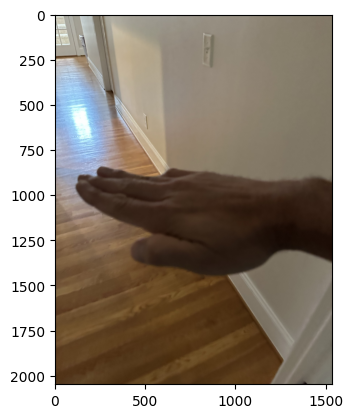

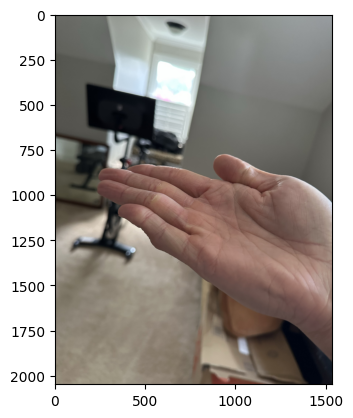

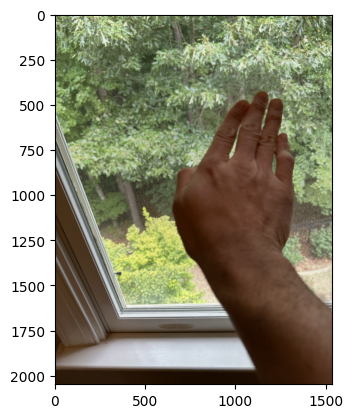

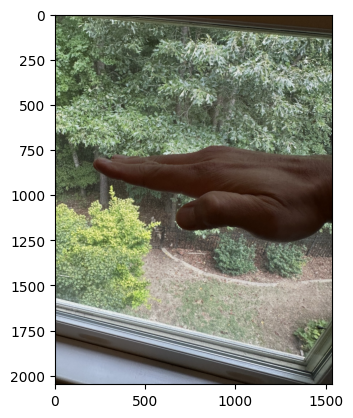

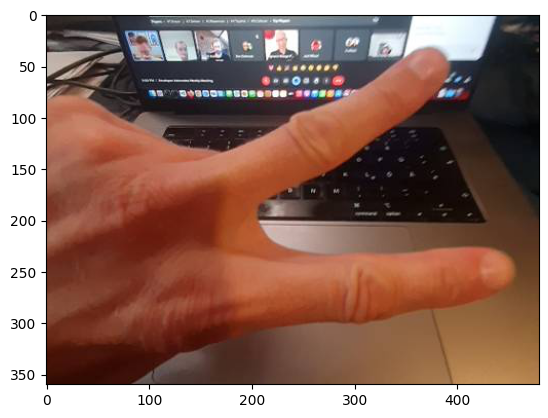

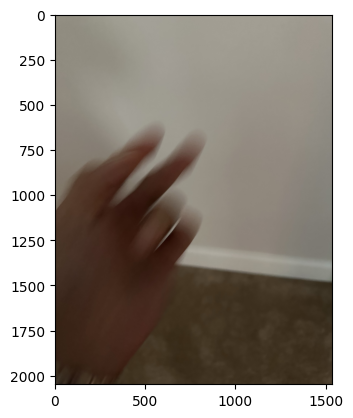

In [74]:
for f in np.array(fname_list)[incorrect_idx]:
    img = Image.open(f)
    
    plt.figure()
    plt.imshow(img)